![Logo](logo.jpg)

# Transformer Experiment Code Description

## Overview
This code implements a comprehensive study of positional encoding in Transformer models, focusing on different encoding methods and their visualization. It's designed as an educational tool to understand how Transformers handle sequential data and position information.

## Main Components

### 1. TransformerExperiment Class

### 2. Positional Encoding Implementations

#### a) Standard Sinusoidal Encoding (`positional_encoding_exercise`):
- Implements the original positional encoding from "Attention is All You Need"
- Uses sine and cosine functions of different frequencies
- Creates unique position representations for each position in the sequence
- Good for tasks requiring absolute position information

#### b) Learned Positional Encoding (`LearnedPositionalEncoding` class):
- Implements learnable position embeddings
- Initializes random position embeddings that are optimized during training
- Allows the model to learn optimal position representations
- Useful for task-specific position encoding

### 3. Training and Visualization

#### a) Training Process (`train_positional_encoding`):
- Trains a simple sequence model with learned positional encoding
- Uses MSE loss to predict positions in sequences
- Includes noise injection during early training for better exploration
- Captures snapshots of the encoding at different training stages

#### b) Visualization Tools:
- Compares different encoding methods (standard, relative, learned)
- Shows training progress with loss curves
- Visualizes the evolution of learned encodings
- Displays changes between training epochs
- Tracks the evolution of specific dimensions


In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [14]:
class TransformerExperiment:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def generate_sequence_data(self, length=50):
        """Generates a sequence containing a hidden pattern to detect"""
        # Create a sequence with a hidden pattern: peak every 7 numbers
        x = torch.zeros(length)
        for i in range(0, length, 7):
            x[i] = 1.0
        # Add noise
        x += torch.randn(length) * 0.1
        return x

    def create_simple_transformer(self, d_model=32, nhead=4, num_layers=2):
        """Creates a simple Transformer model"""
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward=128)
        return TransformerEncoder(encoder_layers, num_layers)

    def positional_encoding_exercise(self, seq_length=50, d_model=32):
        """
        Standard sinusoidal positional encoding from "Attention is All You Need" paper.
        
        Use cases:
        - When absolute positions are important (e.g., sequence classification)
        - For tasks requiring precise position information (e.g., machine translation)
        - When you need deterministic, reproducible encoding
        - For tasks where the model needs to know exact positions in sequence
        - Good default choice for most transformer applications
        
        Example applications:
        - Machine translation (word order matters)
        - Text classification (position of words is important)
        - Named entity recognition (position helps identify entities)
        """
        # Create position indices [0, 1, 2, ..., seq_length-1] and reshape to [seq_length, 1]
        # This will be used to generate different frequencies for each position
        position = torch.arange(seq_length).unsqueeze(1)
        
        # Create division term for different frequencies
        # For each dimension i, we use a different frequency: 1/10000^(i/d_model)
        # We only need half of d_model frequencies because we'll use both sin and cos
        # The exponential term creates a geometric sequence of frequencies
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        
        # Initialize the positional encoding matrix with zeros
        # Shape: [seq_length, d_model]
        pos_encoding = torch.zeros(seq_length, d_model)
        
        # Apply sine function to even indices (0, 2, 4, ...)
        # This creates a unique pattern for each position
        # The multiplication of position and div_term creates different frequencies
        # for different dimensions, allowing the model to learn different aspects of position
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        
        # Apply cosine function to odd indices (1, 3, 5, ...)
        # Using both sine and cosine allows the model to:
        # 1. Learn absolute positions (through different frequencies)
        # 2. Learn relative positions (through phase shifts)
        # 3. Have unique representations for each position
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        
        return pos_encoding

    class LearnedPositionalEncoding(nn.Module):
        """
        Alternative to sinusoidal encoding where the model learns optimal position representations.
        Instead of using fixed sine/cosine functions, this learns position embeddings through training.
        """
        def __init__(self, seq_length, d_model):
            super().__init__()
            # Initialize random position embeddings that will be learned during training
            # Shape: [seq_length, d_model] - one embedding vector for each position
            self.pos_embedding = nn.Parameter(torch.randn(seq_length, d_model))
            
        def forward(self, x):
            # Add learned position embeddings to input embeddings
            # This allows the model to learn how to represent positions optimally
            return x + self.pos_embedding

    class SimpleSequenceModel(nn.Module):
        """
        A simple neural network that learns to predict positions in a sequence.
        It combines learned positional encoding with two linear layers to learn
        patterns in sequential data.
        """
        def __init__(self, seq_length, d_model):
            super().__init__()
            # Learned positional encoding layer - learns optimal position representations
            self.pos_encoding = TransformerExperiment.LearnedPositionalEncoding(seq_length, d_model)
            
            # First linear layer with ReLU activation - learns complex patterns
            self.linear1 = nn.Linear(d_model, d_model)
            
            # Final linear layer - reduces to single output (predicted position)
            self.linear2 = nn.Linear(d_model, 1)
            
        def forward(self, x):
            # Add learned position embeddings to input
            x = self.pos_encoding(x)
            
            # Apply first linear layer with ReLU activation
            # ReLU helps model learn non-linear patterns
            x = torch.relu(self.linear1(x))
            
            # Final linear layer produces position prediction
            x = self.linear2(x)
            return x

    def train_positional_encoding(self, seq_length=50, d_model=32, epochs=200):
        """Exercise 1: Training and visualizing learned positional encoding"""
        # Create synthetic task: predict position in sequence
        X = torch.zeros(seq_length, d_model)  # Input: empty tensor
        y = torch.arange(seq_length).float().unsqueeze(1)  # Target: position index
        
        # Create model and optimizer
        model = self.SimpleSequenceModel(seq_length, d_model)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Lists to store visualization data
        losses = []
        encoding_snapshots = []
        
        # Training loop
        snapshot_epochs = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200]
        
        # We add random noise to the initialization
        with torch.no_grad():
            model.pos_encoding.pos_embedding.data *= 0.1  # Smaller initialization
            
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            output = model(X)
            loss = nn.MSELoss()(output, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            # Save positional encoding snapshot at specific epochs
            if epoch in snapshot_epochs:
                encoding_snapshots.append({
                    'epoch': epoch,
                    'encoding': model.pos_encoding.pos_embedding.detach().clone()
                })
                
            # We add small noise to the encoding during training
            if epoch < 50:  # Only in the initial phase
                with torch.no_grad():
                    noise = torch.randn_like(model.pos_encoding.pos_embedding) * 0.01
                    model.pos_encoding.pos_embedding.add_(noise)
        
        return model, losses, encoding_snapshots

    def custom_positional_encoding(self, seq_length=50, d_model=32):
        """
        Custom positional encoding with different types of position representations.
        
        Learned encoding (encoding_type="learned"):
        Use cases:
        - When the optimal position representation is task-specific
        - For tasks where standard encoding might not be optimal
        - When you want the model to learn the best position representation
        - For complex tasks where position patterns are not obvious
        
        Example applications:
        - Complex sequence modeling tasks
        - Domain-specific NLP tasks
        - Tasks with unusual position patterns
        - When you want to experiment with different position representations
        """
        
        pos_encoding = nn.Parameter(torch.randn(seq_length, d_model))
        return pos_encoding
        
    

# Task 1: Positional Encoding Study


=== Task 1: Positional Encoding Study ===


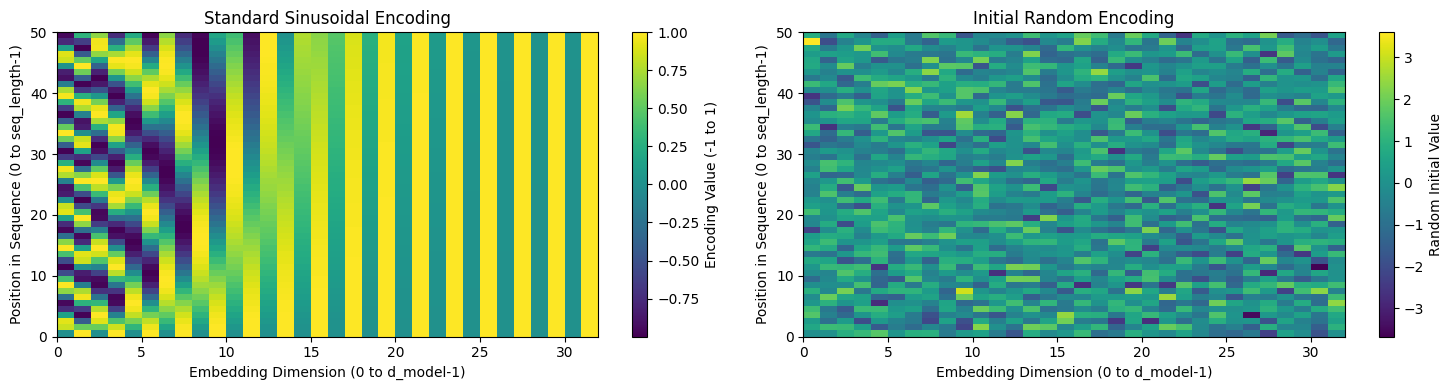

In [15]:
experiment = TransformerExperiment()
    
    
# Task 1: Positional Encoding Study
print("\n=== Task 1: Positional Encoding Study ===")

# Compare different encoding methods
seq_length, d_model = 50, 32

# Different types of positional encoding
plt.figure(figsize=(15, 4))

# Standard encoding
pos_encoding_standard = experiment.positional_encoding_exercise(seq_length, d_model)
plt.subplot(121)
plt.pcolormesh(pos_encoding_standard.numpy())
plt.title("Standard Sinusoidal Encoding")
plt.xlabel("Embedding Dimension (0 to d_model-1)")
plt.ylabel("Position in Sequence (0 to seq_length-1)")
plt.colorbar(label="Encoding Value (-1 to 1)")

# Initial learned encoding
initial_encoding = experiment.custom_positional_encoding(
    seq_length, d_model
)
plt.subplot(122)
plt.pcolormesh(initial_encoding.detach().numpy())
plt.title("Initial Random Encoding")
plt.xlabel("Embedding Dimension (0 to d_model-1)")
plt.ylabel("Position in Sequence (0 to seq_length-1)")
plt.colorbar(label="Random Initial Value")

plt.tight_layout()
plt.show()

## Train and visualize learned encoding

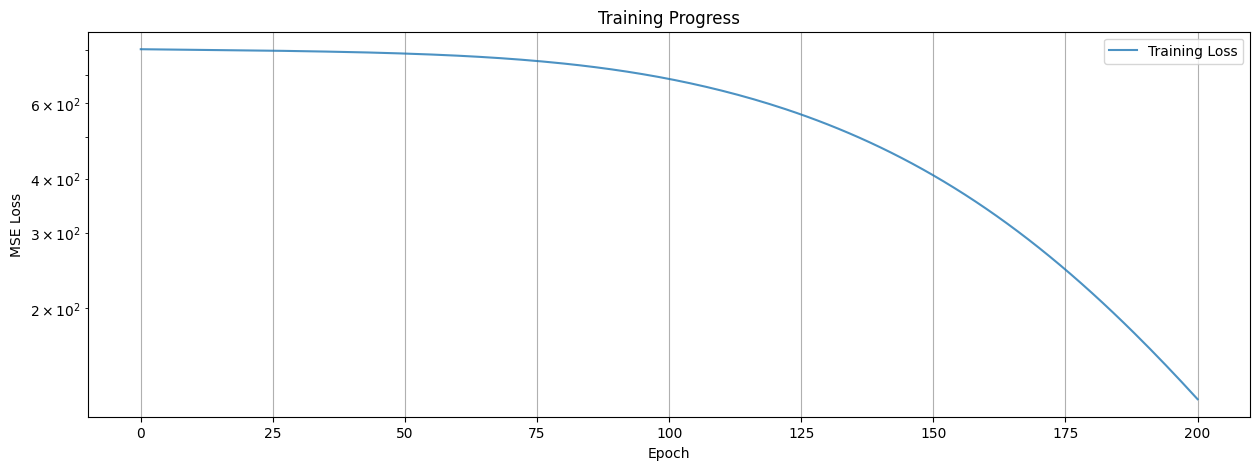

In [16]:
# Train and visualize learned encoding
model, losses, snapshots = experiment.train_positional_encoding(
    seq_length=seq_length, 
    d_model=d_model, 
    epochs=200
)

# Training progress - pierwszy wykres po treningu
plt.figure(figsize=(15, 5))
plt.plot(losses, alpha=0.8, label='Training Loss')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')  # Log scale to better see the early changes
plt.grid(True)
plt.legend()
plt.show()

## Visualization of learning process 

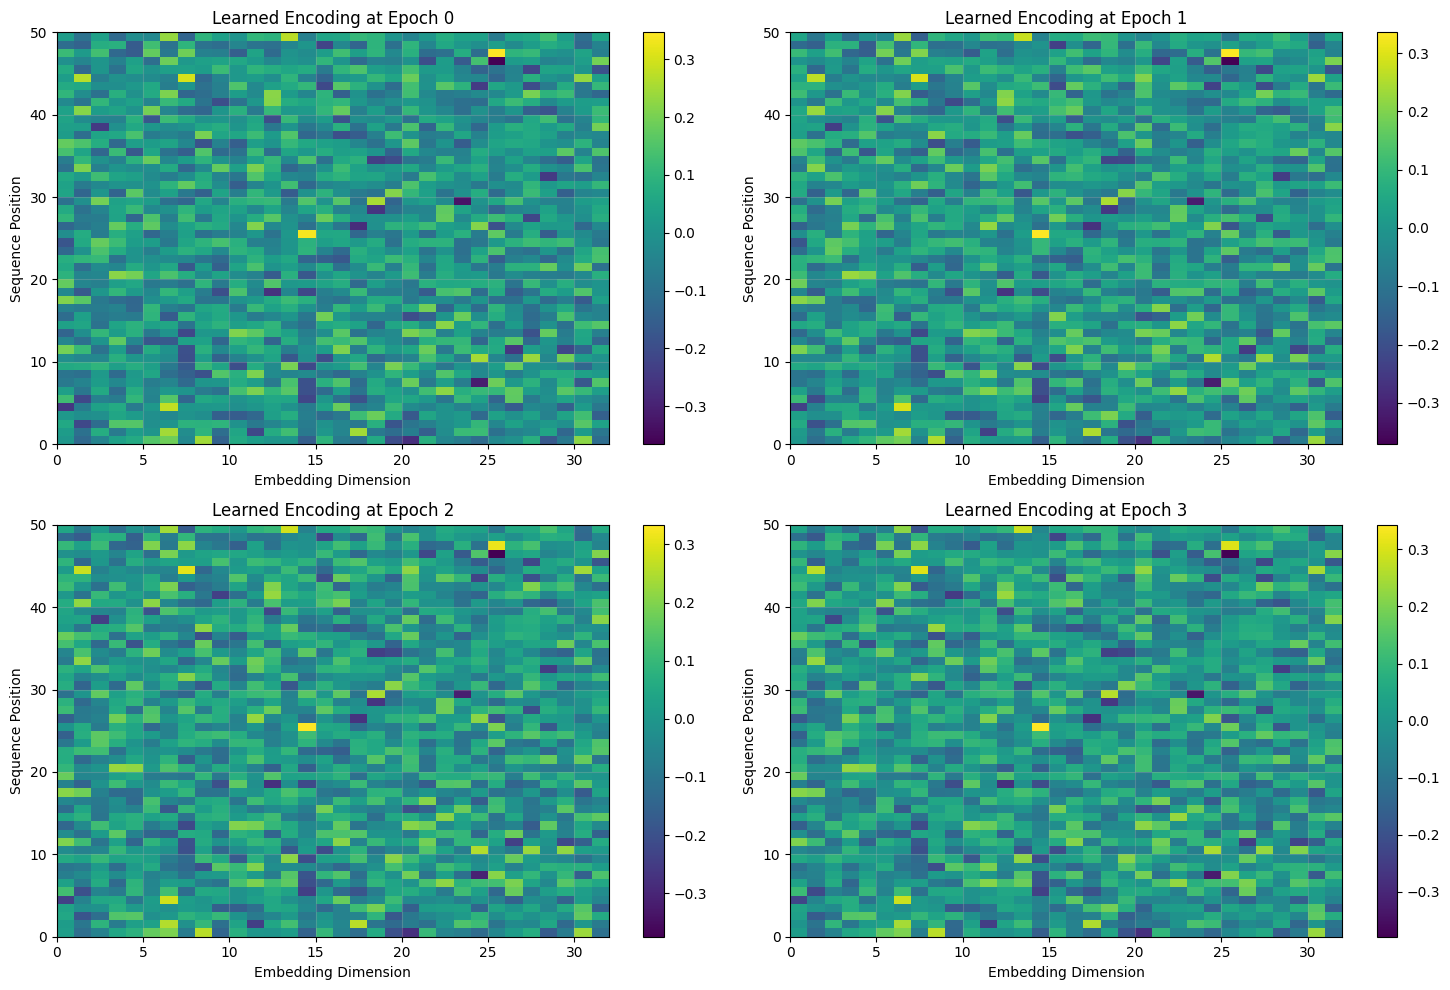

In [17]:
# Visualization of learning process 
plt.figure(figsize=(15, 10))

# Plot snapshots at different stages
for idx, snapshot in enumerate(snapshots[:4]):  # Show first 4 snapshots
    plt.subplot(2, 2, idx+1)
    
    # Używamy osobnej skali kolorów dla każdego snapshotu
    im = plt.pcolormesh(snapshot['encoding'].numpy())
    plt.colorbar(im)
    
    plt.title(f"Learned Encoding at Epoch {snapshot['epoch']}")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Sequence Position")
    
    # Dodajemy siatkę
    plt.grid(True, which='major', linestyle='-', alpha=0.3)
    
    # Ustawiamy limity osi, aby były takie same dla wszystkich wykresów
    plt.xlim(0, d_model)
    plt.ylim(0, seq_length)

plt.tight_layout()
plt.show()

## Visualization of changes between epochs 

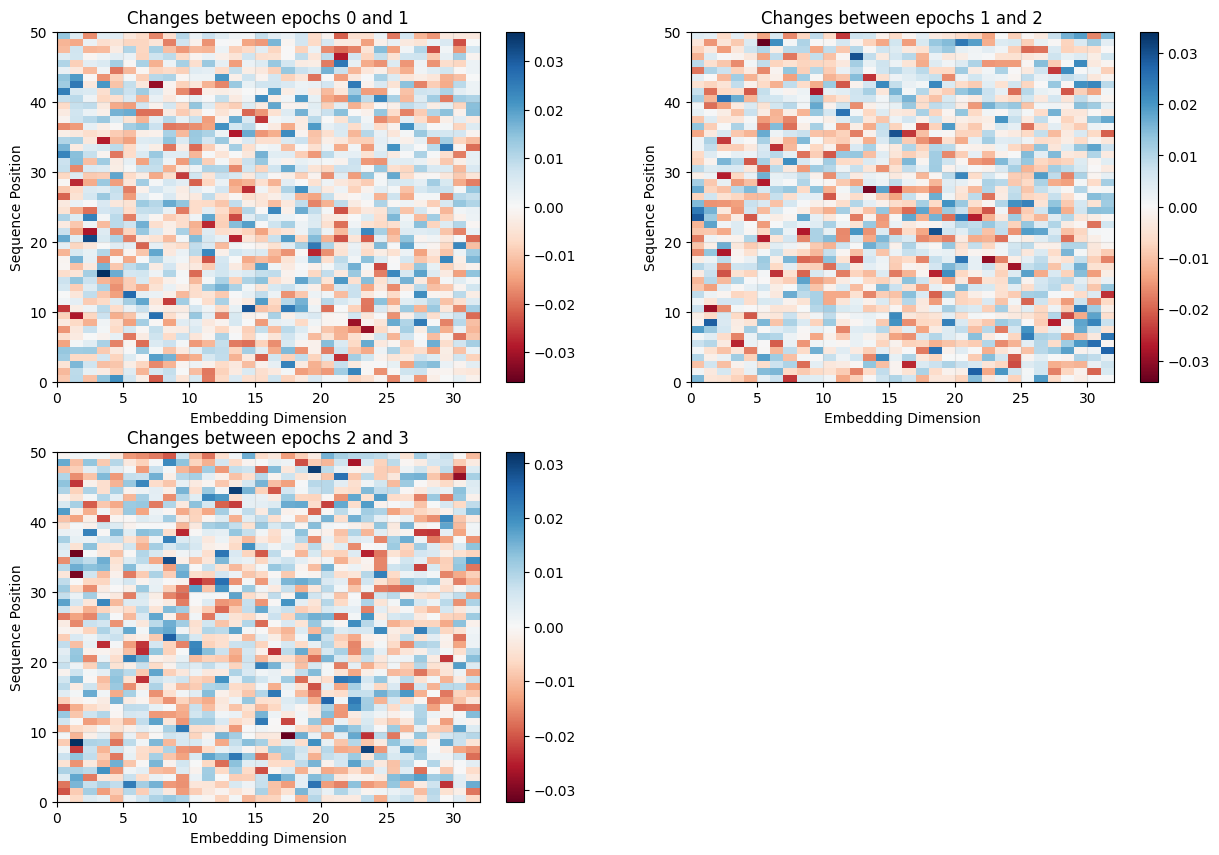

In [18]:
# Visualization of changes between epochs 
plt.figure(figsize=(15, 10))

for idx in range(3):  # Pokaż różnice między kolejnymi snapshotami
    plt.subplot(2, 2, idx+1)
    
    # Obliczamy różnicę między kolejnymi snapshotami
    diff = snapshots[idx+1]['encoding'].numpy() - snapshots[idx]['encoding'].numpy()
    
    # Remove the 'center' parameter and use vmin/vmax instead to center the colormap
    max_abs = np.abs(diff).max()
    im = plt.pcolormesh(diff, cmap='RdBu', vmin=-max_abs, vmax=max_abs)
    plt.colorbar(im)
    
    plt.title(f"Changes between epochs {snapshots[idx]['epoch']} and {snapshots[idx+1]['epoch']}")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Sequence Position")
    
    plt.grid(True, which='major', linestyle='-', alpha=0.3)
    plt.xlim(0, d_model)
    plt.ylim(0, seq_length)

## Evolution of specific dimensions

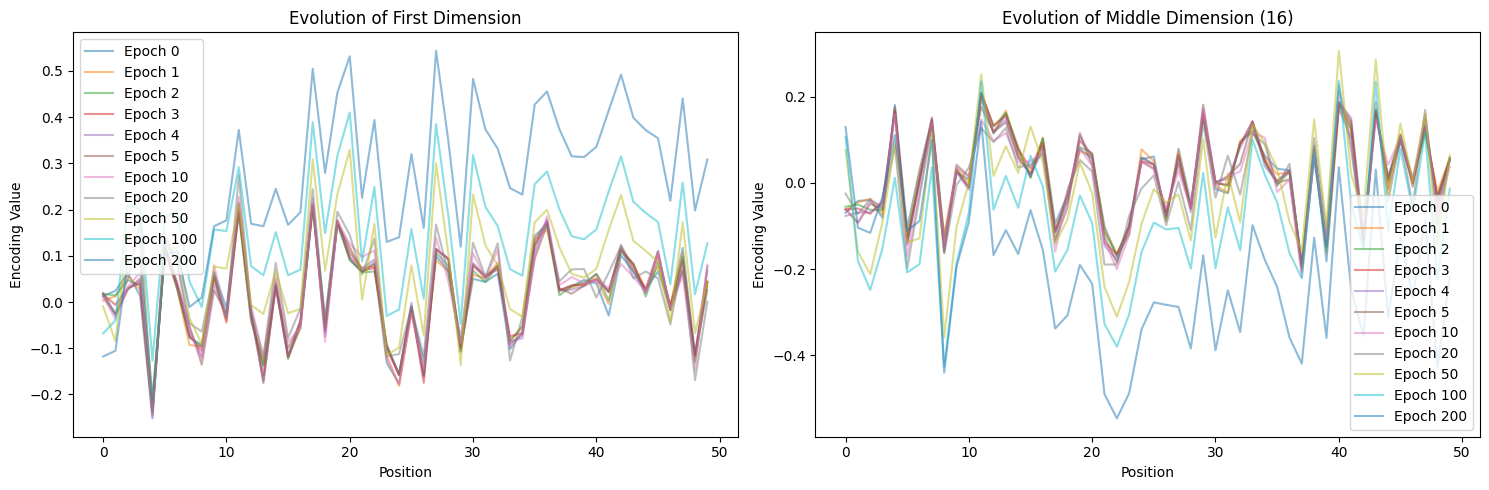

In [19]:
# Evolution of specific dimensions 
plt.figure(figsize=(15, 5))

# Plot evolution of first dimension
plt.subplot(121)
for snapshot in snapshots:
    plt.plot(snapshot['encoding'][:, 0].numpy(), alpha=0.5, 
            label=f"Epoch {snapshot['epoch']}")
plt.title("Evolution of First Dimension")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.legend()

# Plot evolution of middle dimension
plt.subplot(122)
mid_dim = d_model // 2
for snapshot in snapshots:
    plt.plot(snapshot['encoding'][:, mid_dim].numpy(), alpha=0.5, 
            label=f"Epoch {snapshot['epoch']}")
plt.title(f"Evolution of Middle Dimension ({mid_dim})")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.legend()

plt.tight_layout()
plt.show()